In [6]:
import numpy as np
import librosa
import librosa.display
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
def log_mel(user_mp3, sample_rate=22050, n_mels=128, n_fft=2048, hop_length=512, fmin=27.5, fmax=8000):
    # Load audio file
    y, sr = librosa.load(user_mp3, sr=sample_rate, mono=True)
    
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax)
    
    # Apply Gaussian filter
    mel_spectrogram = gaussian_filter(mel_spectrogram, sigma=(0.8,0.3))

    # Convert to log scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return log_mel_spectrogram

In [3]:
def normalize_spectogram(spectogram):
    mu = spectogram.mean(axis=1, keepdims=True)
    sigma = spectogram.std(axis=1, keepdims=True)
    return (spectogram - mu) / sigma


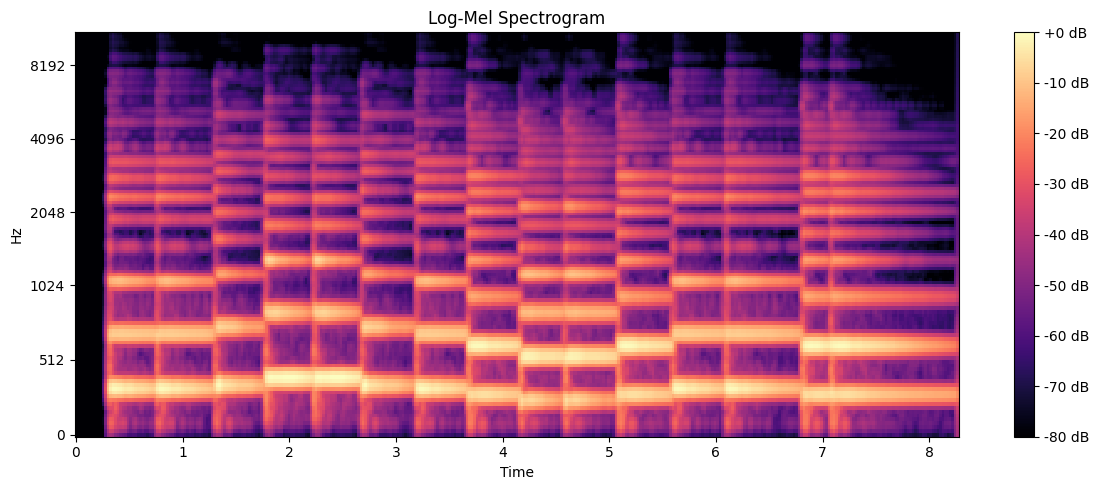

In [ ]:
# visualize the first 8 seconds of the log-mel spectrogram for a good Ode to Joy practice
mp3_path = 'practiceode.mp3'
log_mel_spectrogram = log_mel(mp3_path)
normalized_spectrogram = normalize_spectogram(log_mel_spectrogram)

ipd.display(ipd.Audio(mp3_path))

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    log_mel_spectrogram,
    sr=22050,
    hop_length=512,
    x_axis="time",
    y_axis="mel",
)

plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()

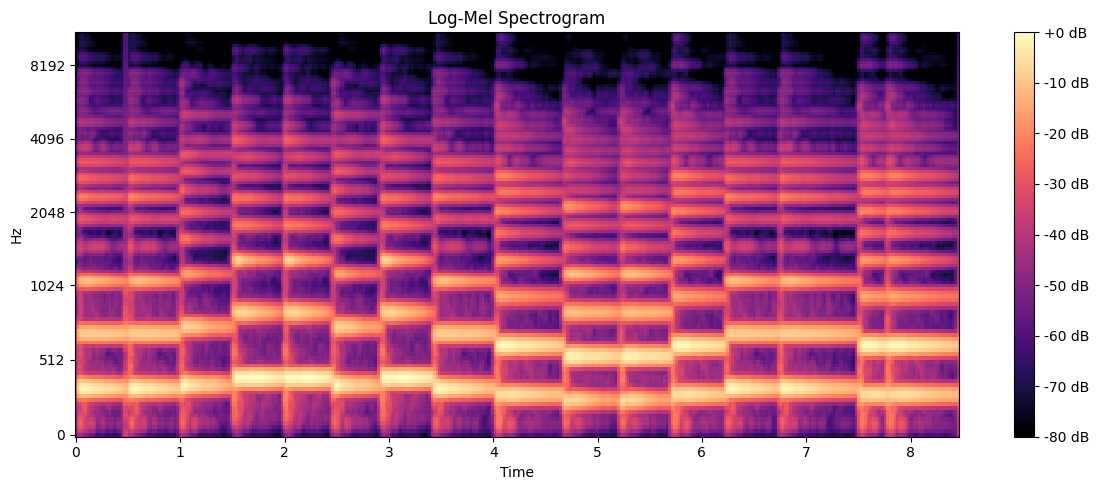

In [ ]:
# visualize the first 8 seconds of the log-mel spectrogram for a not so good Ode to Joy practice
mp3_path = 'badode.mp3'
log_mel_spectrogram = log_mel(mp3_path)
normalized_spectrogram = normalize_spectogram(log_mel_spectrogram)

ipd.display(ipd.Audio(mp3_path))

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    log_mel_spectrogram,
    sr=22050,
    hop_length=512,
    x_axis="time",
    y_axis="mel",
)

plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()

In [ ]:
def gaussian_pyramid(spectogram, levels=4, sigma=1, downscale=2, minsize=16):
    pyramid = [spectogram]
    current_level = spectogram
    for _ in range(1, levels):
        # Apply Gaussian filter
        blurred = gaussian_filter(current_level, sigma=sigma)
        # Downsample the spectrogram
        downsampled = blurred[::downscale, ::downscale]
        if downsampled.shape[0] < minsize or downsampled.shape[1] < minsize:
            break
        pyramid.append(downsampled)
        current_level = downsampled
    return pyramid

In [ ]:
ideal_pyr = gaussian_pyramid(S_ideal, levels=4, sigma=1.0, downscale=2)
prac_pyr  = gaussian_pyramid(S_prac,  levels=4, sigma=1.0, downscale=2)

Utility Functions for Step-wise Dynamic Time Warp

In [ ]:
def upscale_path(path, scale_i, scale_j, max_i, max_j):
    up = [(min(max_i-1, int(i * scale_i)), min(max_j-1, int(j * scale_j))) for i, j in path]
    up_sorted = []
    last = (-1, -1)
    for p in up:
        if p != last:
            up_sorted.append(p)
            last = p
    return up_sorted

def create_centerline(path, len_i):
    center = np.full(len_i, -1, dtype=np.int32)
    for i, j in path:
        if 0 <= i < len_i:
            center[i] = j
    
    last = 0
    for i in range(len_i):
        if center[i] == -1:
            center[i] = center[last]
        else:
            last = i
    return center

def create_corridor(centerline, width, len_j):
    corridor = np.zeros((len(centerline), len_j), dtype=bool)
    for i, center_j in enumerate(centerline):
        if center_j != -1:
            start = max(0, center_j - width)
            end = min(len_j, center_j + width + 1)
            corridor[i, start:end] = True
    return corridor